## Import Library

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

## Load Price Data

In [16]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_15minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    raw_data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    raw_data = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_15minutes.csv", index_col='Date', parse_dates=True)
raw_data.tail(10)
ticker_data = raw_data[["Open", "Close", "Low", "High", "Volume"]]
ticker_data.columns = ["open", "close", "low", "high", "volume"]
ticker_data

,open,close,low,high,volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.1,942.6,943.6,4342
2018-08-13 09:15:00,943.1,945.3,942.3,945.9,5430
2018-08-13 09:30:00,945.2,944.5,943.3,945.5,4933
2018-08-13 09:45:00,944.5,946.0,944.3,946.4,4254
2018-08-13 10:00:00,945.9,945.2,944.5,946.3,4336
...,...,...,...,...,...
2024-07-23 13:45:00,1296.3,1295.5,1294.2,1297.0,17686
2024-07-23 14:00:00,1295.5,1295.3,1294.7,1297.2,12769
2024-07-23 14:15:00,1295.3,1287.5,1280.1,1295.3,49920


In [17]:
#@title Raw Price
def cal_first_close(tick):
  if not tick.empty:
    return tick[0]


def cal_high(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 925]
  tick = tick[100*tick.index.hour+tick.index.minute < 1345]
  return tick.max()


def cal_low(tick):
  tick = tick[100*tick.index.hour+tick.index.minute > 925]
  tick = tick[100*tick.index.hour+tick.index.minute < 1345]
  return tick.min()


def cal_price(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1345]
  if not tick.empty:
    return tick[0]

def cal_close(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1415]
  if not tick.empty:
    return tick[0]

price = ticker_data
price['first_close'] = price.close
price['price'] = price.close
price = price.resample("D").agg({
    'first_close': cal_first_close,
    'high':cal_high,
    'low': cal_low,
    'price': cal_price,
    'close': cal_close
    })
raw = price.dropna()

In [18]:
price = raw.copy()
price['percent'] = 100 * (price.price - price.close.shift(1)) / price.close.shift(1)
price['returns'] = (price.price - price.first_close) / (price.high - price.low)
price['return'] = 1000 * (price.close - price.price) / price.price
price.tail(10)

,first_close,high,low,price,close,percent,returns,return
Date,,,,,,,,
2024-07-10,1319.9,1321.9,1313.6,1316.3,1310.3,-0.242516,-0.433735,-4.558231
2024-07-11,1315.5,1317.9,1310.2,1312.2,1306.6,0.145005,-0.428571,-4.267642
2024-07-12,1304.2,1310.0,1300.8,1302.8,1299.5,-0.290831,-0.152174,-2.533006
2024-07-15,1303.3,1305.6,1299.4,1299.9,1297.0,0.030781,-0.548387,-2.230941
2024-07-16,1301.0,1308.7,1301.1,1303.1,1301.8,0.470316,0.276316,-0.997621
2024-07-17,1308.8,1314.0,1301.7,1314.0,1296.9,0.937164,0.422764,-13.013699
2024-07-18,1303.5,1304.0,1291.6,1291.6,1297.7,-0.408667,-0.959677,4.722824
2024-07-19,1304.0,1311.2,1299.1,1303.0,1302.2,0.408415,-0.082645,-0.613968
2024-07-22,1294.1,1304.4,1292.4,1294.2,1299.0,-0.614345,0.008333,3.708855


### return distributions

In [19]:
price['return'].describe()

count    1481.000000
mean       -0.163798
std         5.900533
min       -27.832377
25%        -2.709848
50%         0.169062
75%         2.854696
max        29.089314
Name: return, dtype: float64

In [20]:
price['return_group'] = pd.cut(price['return'], 30)
s1 = price.groupby(['return_group'])[['return']].count()
f1 = s1[['return']].rename(columns={'return': 'count'})
price.drop(columns=['return_group'], inplace=True)
f1

,count
return_group,
"(-27.889, -25.935]",1
"(-25.935, -24.038]",2
"(-24.038, -22.14]",0
"(-22.14, -20.243]",6
"(-20.243, -18.345]",5
"(-18.345, -16.448]",7
"(-16.448, -14.551]",14
"(-14.551, -12.653]",14
"(-12.653, -10.756]",17


In [21]:
price = price[price['return'] > -16.5]
price = price[price['return'] <  12.1]

### percent distributions

In [22]:
price['percent'].describe()

count    1432.000000
mean        0.053899
std         1.221133
min        -7.200119
25%        -0.395060
50%         0.098103
75%         0.621972
max         7.145188
Name: percent, dtype: float64

In [23]:
price['returns'].describe()

count    1433.000000
mean        0.003242
std         0.666167
min        -1.840000
25%        -0.516484
50%         0.000000
75%         0.534091
max         1.846847
Name: returns, dtype: float64

In [24]:
price['percent_group'] = pd.qcut(price.percent, 30)
price['returns_group'] = pd.qcut(price.returns, 36)

## Analysis

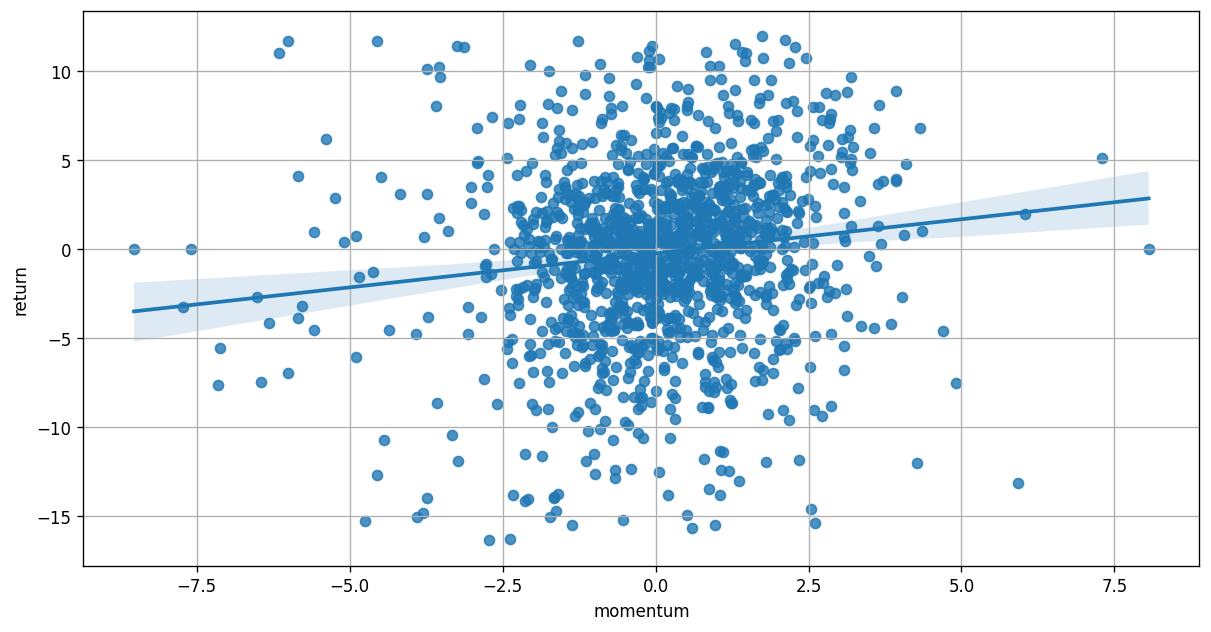

In [25]:
price['momentum'] = price.percent + price.returns
sns.regplot(x=price['momentum'], y=price['return'])
plt.grid(True)

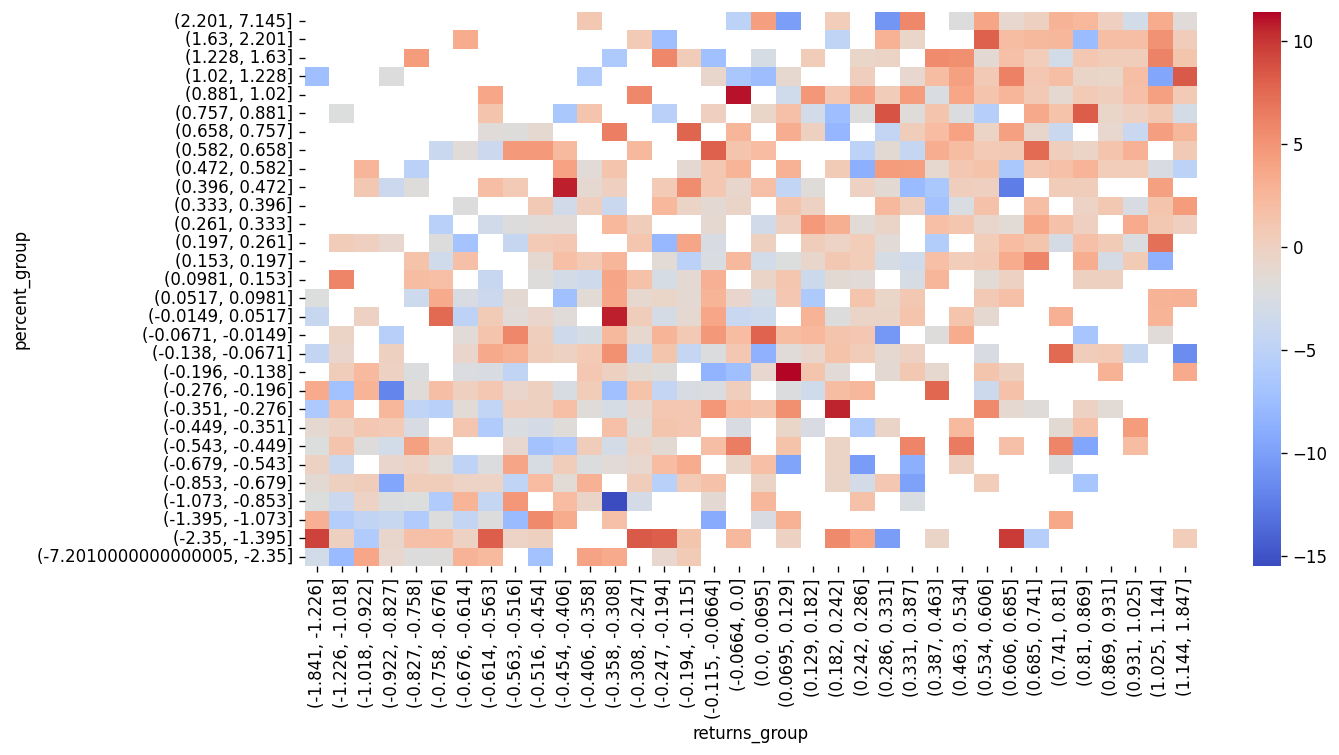

In [26]:
grpd = price.groupby(['percent_group', 'returns_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='percent_group', columns='returns_group', values='return').sort_index(ascending=False), cmap = 'coolwarm');

## Long

In [27]:
Long = price[price.percent > .26]
Long = Long[Long.returns > .39]
Long

,first_close,high,low,price,close,percent,returns,return,percent_group,returns_group,momentum
Date,,,,,,,,,,,
2018-08-14,955.0,958.6,952.1,959.5,960.1,0.565978,0.692308,0.625326,"(0.472, 0.582]","(0.685, 0.741]",1.258286
2018-08-21,944.9,950.8,944.5,950.1,954.7,0.571610,0.825397,4.841596,"(0.472, 0.582]","(0.81, 0.869]",1.397007
2018-08-23,957.0,959.9,955.8,962.6,961.0,0.785258,1.365854,-1.662165,"(0.757, 0.881]","(1.144, 1.847]",2.151112
2018-08-27,961.7,965.2,961.5,963.7,963.0,0.500574,0.540541,-0.726367,"(0.472, 0.582]","(0.534, 0.606]",1.041114
2018-09-07,934.5,942.6,930.5,941.3,944.8,0.630746,0.561983,3.718262,"(0.582, 0.658]","(0.534, 0.606]",1.192730
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,1303.0,1312.9,1302.5,1313.9,1328.4,0.435713,1.048077,11.035847,"(0.396, 0.472]","(1.025, 1.144]",1.483790
2024-06-18,1312.6,1318.7,1311.4,1321.4,1309.5,0.877930,1.205479,-9.005600,"(0.757, 0.881]","(1.144, 1.847]",2.083409
2024-07-02,1287.4,1299.0,1284.6,1297.1,1296.6,0.957347,0.673611,-0.385475,"(0.881, 1.02]","(0.606, 0.685]",1.630959


In [32]:
Long = Long[Long.high != Long.first_close]
Long['tail'] = (Long.high - Long.price) / (Long.high - Long.first_close)
Long['tail'].describe()

count    328.000000
mean      -0.000024
std        0.498033
min       -5.875000
25%       -0.113432
50%        0.072018
75%        0.238563
max        0.644444
Name: tail, dtype: float64

In [33]:
Long['tail_group'] = pd.qcut(Long['tail'], 18, duplicates='drop')
Long[['return', 'tail_group']].groupby(['tail_group']).mean()
Long

,first_close,high,low,price,close,percent,returns,return,percent_group,returns_group,momentum,tail,tail_group
Date,,,,,,,,,,,,,
2018-08-14,955.0,958.6,952.1,959.5,960.1,0.565978,0.692308,0.625326,"(0.472, 0.582]","(0.685, 0.741]",1.258286,-0.250000,"(-0.318, -0.215]"
2018-08-21,944.9,950.8,944.5,950.1,954.7,0.571610,0.825397,4.841596,"(0.472, 0.582]","(0.81, 0.869]",1.397007,0.118644,"(0.103, 0.14]"
2018-08-23,957.0,959.9,955.8,962.6,961.0,0.785258,1.365854,-1.662165,"(0.757, 0.881]","(1.144, 1.847]",2.151112,-0.931034,"(-5.876, -0.533]"
2018-08-27,961.7,965.2,961.5,963.7,963.0,0.500574,0.540541,-0.726367,"(0.472, 0.582]","(0.534, 0.606]",1.041114,0.428571,"(0.356, 0.446]"
2018-09-07,934.5,942.6,930.5,941.3,944.8,0.630746,0.561983,3.718262,"(0.582, 0.658]","(0.534, 0.606]",1.192730,0.160494,"(0.14, 0.175]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-12,1303.0,1312.9,1302.5,1313.9,1328.4,0.435713,1.048077,11.035847,"(0.396, 0.472]","(1.025, 1.144]",1.483790,-0.101010,"(-0.137, -0.0914]"
2024-06-18,1312.6,1318.7,1311.4,1321.4,1309.5,0.877930,1.205479,-9.005600,"(0.757, 0.881]","(1.144, 1.847]",2.083409,-0.442623,"(-0.533, -0.318]"
2024-07-02,1287.4,1299.0,1284.6,1297.1,1296.6,0.957347,0.673611,-0.385475,"(0.881, 1.02]","(0.606, 0.685]",1.630959,0.163793,"(0.14, 0.175]"


In [34]:
Long['return'].sum()

325.8757106837495

In [35]:
this_month = Long[(Long.index > '2024-06-01 00:00:00') & (Long.index < '2024-06-30 15:00:00')]
this_month['return'].sum()

-0.20637149340488925

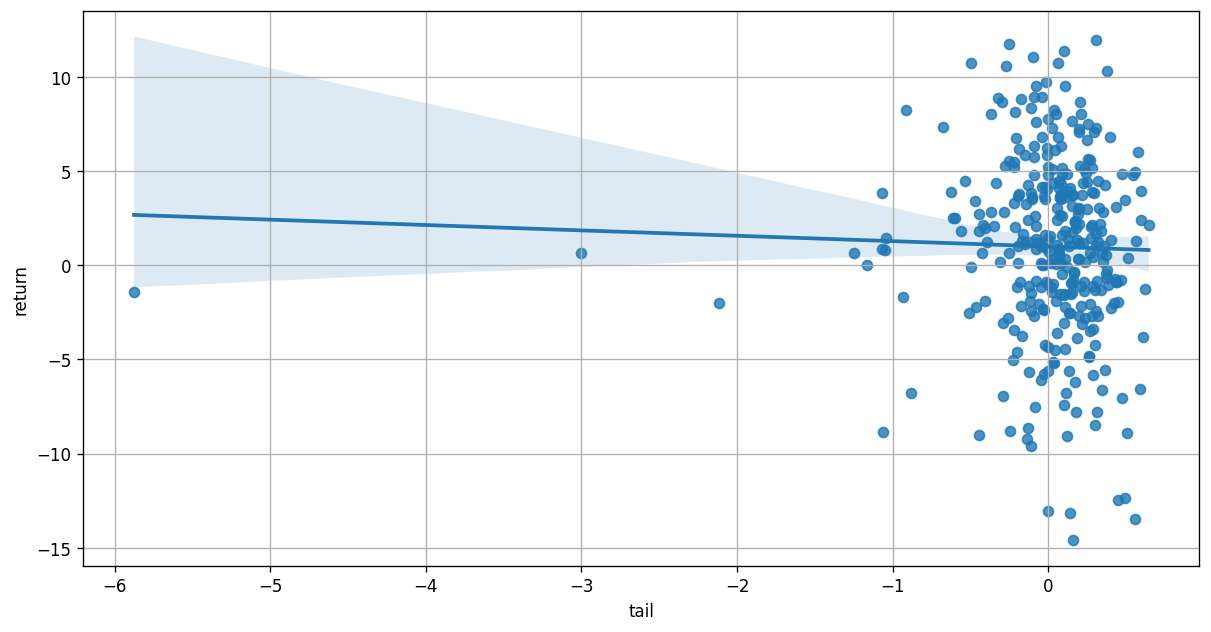

In [36]:
sns.regplot(x=Long['tail'], y=Long['return'])
plt.grid(True)

## Short

In [37]:
Short = price[price.percent < -.18]
Short = Short[Short.returns < -.39]

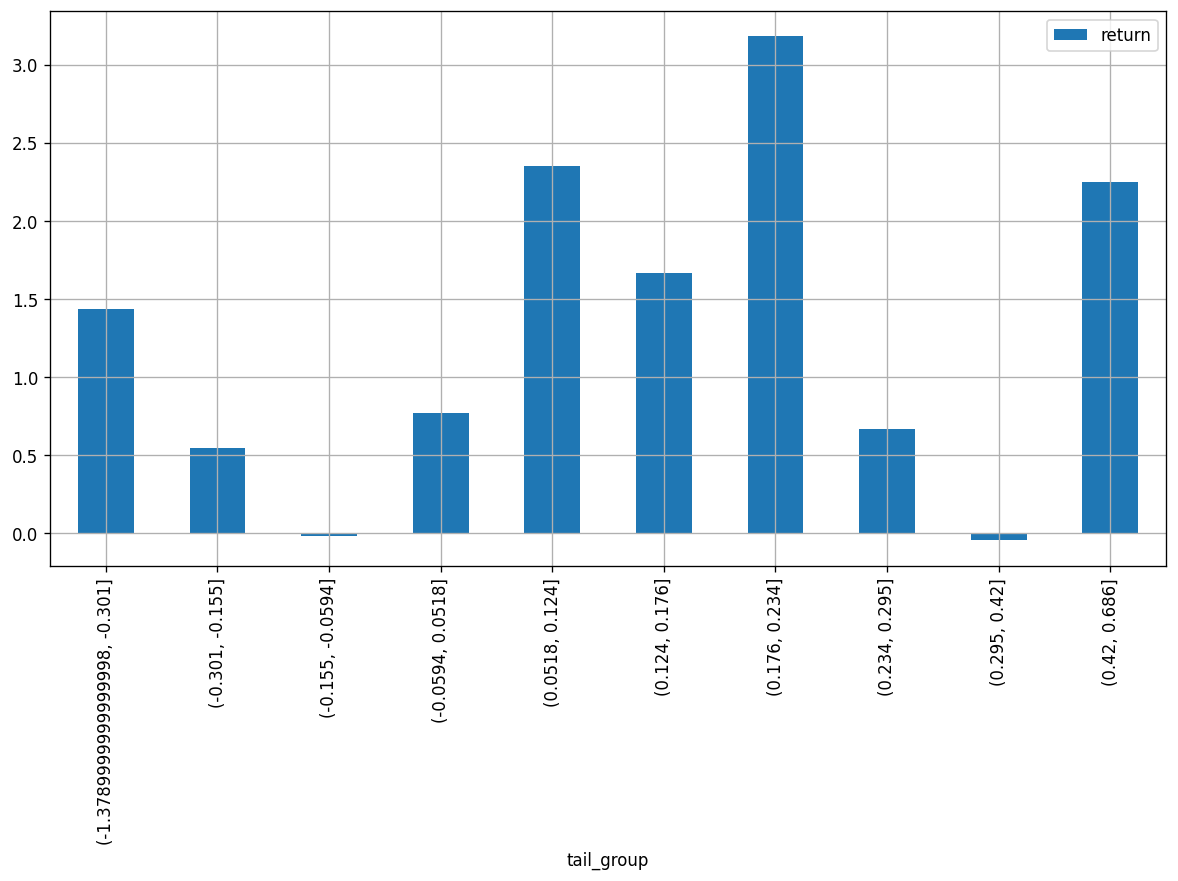

In [38]:
Short = Short[Short.high != Short.low]
Short['tail'] = (Short.price - Short.low) / (Short.high - Short.low)
Short['tail_group'] = pd.qcut(Short['tail'], 10)
(-Short[['return', 'tail_group']].groupby(['tail_group']).mean()).plot.bar()
plt.grid(True)

In [39]:
Short

,first_close,high,low,price,close,percent,returns,return,percent_group,returns_group,momentum,tail,tail_group
Date,,,,,,,,,,,,,
2018-08-29,965.8,965.9,963.4,962.3,963.9,-0.372709,-1.400000,1.662683,"(-0.449, -0.351]","(-1.841, -1.226]",-1.772709,-0.440000,"(-1.3789999999999998, -0.301]"
2018-09-05,953.0,954.4,945.6,947.4,942.5,-1.003135,-0.636364,-5.172050,"(-1.073, -0.853]","(-0.676, -0.614]",-1.639498,0.204545,"(0.176, 0.234]"
2018-09-06,944.9,945.8,936.6,935.6,935.4,-0.732095,-1.010870,-0.213767,"(-0.853, -0.679]","(-1.018, -0.922]",-1.742965,-0.108696,"(-0.155, -0.0594]"
2018-09-10,942.9,944.8,937.5,936.1,938.0,-0.920830,-0.931507,2.029698,"(-1.073, -0.853]","(-1.018, -0.922]",-1.852337,-0.191781,"(-0.301, -0.155]"
2018-10-05,990.0,990.8,985.8,987.1,982.7,-0.182020,-0.580000,-4.457502,"(-0.196, -0.138]","(-0.614, -0.563]",-0.762020,0.260000,"(0.234, 0.295]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,1291.8,1291.2,1281.8,1283.9,1277.9,-0.457435,-0.840426,-4.673261,"(-0.543, -0.449]","(-0.922, -0.827]",-1.297861,0.223404,"(0.176, 0.234]"
2024-07-08,1316.2,1316.5,1305.6,1310.7,1312.0,-0.417870,-0.504587,0.991836,"(-0.449, -0.351]","(-0.516, -0.454]",-0.922457,0.467890,"(0.42, 0.686]"
2024-07-10,1319.9,1321.9,1313.6,1316.3,1310.3,-0.242516,-0.433735,-4.558231,"(-0.276, -0.196]","(-0.454, -0.406]",-0.676251,0.325301,"(0.295, 0.42]"


In [40]:
abs(Short['return'].sum())

405.88519451656373

In [41]:
short_this_month = Short[(Short.index > '2024-06-01 00:00:00') & (Short.index < '2024-06-30 15:00:00')]
short_this_month['return'].sum()

-9.87854106186384

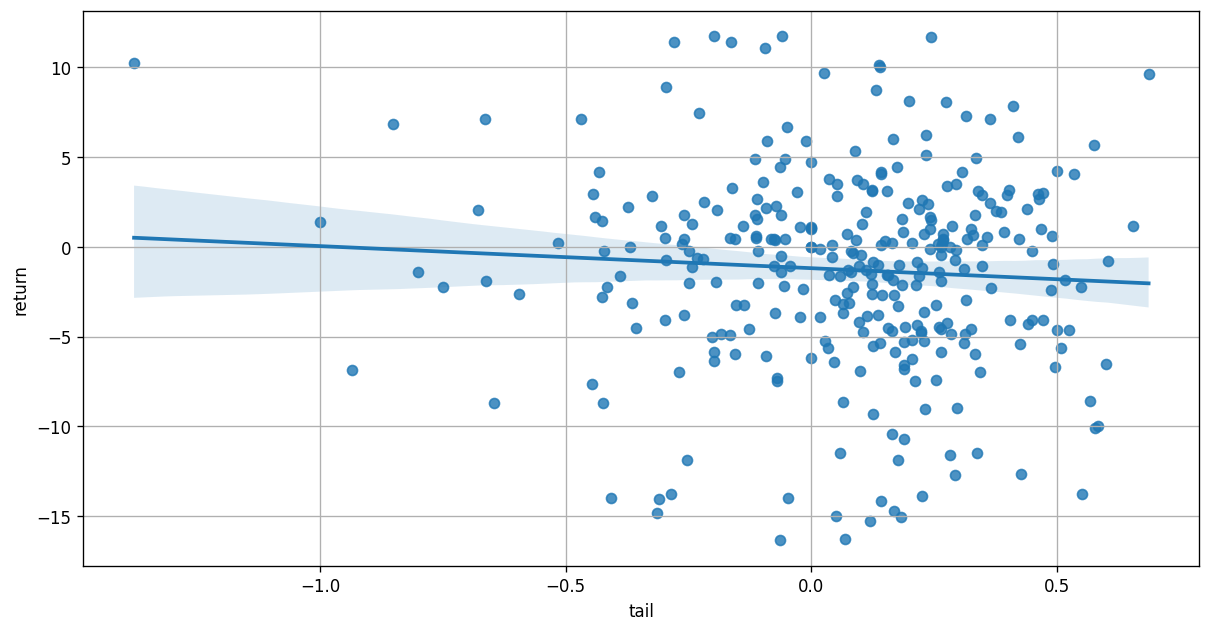

In [42]:
sns.regplot(x=Short['tail'], y=Short['return'])
plt.grid(True)